# Files & imports

In [31]:
from pandas import read_csv, DataFrame
import pandas as pd

In [32]:
#get file from data pre processing notebook. This file has all the column we need to start the data profiling phase
filepath = r'dataset/df_msg_pre_proc.csv'

file_tag = "Ecom Multichannel messages"

data = pd.read_csv(filepath)

In [33]:
%run 'scripts/dslabs_functions.py'

# Load test data

In [34]:
test = False 

def sample_per_day(group, fraction=0.1):
    return group.sample(frac=fraction)

if test==True: 

    sample = 0.01

    data['sent_at'] = pd.to_datetime(data['sent_at']) 
    # Apply the sampling to each group (grouped by event_date) 1%
    data = data.groupby('sent_at').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True) 
   

else: 
    #sample = 0.04

    data['sent_at'] = pd.to_datetime(data['sent_at']) 
    # Apply the sampling to each group (grouped by event_date) 1%
    sampled_data=data.sample(frac=0.01, replace=False)


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203450 entries, 0 to 203449
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   platform                      97107 non-null   object             
 1   email_provider                128165 non-null  object             
 2   sent_at                       203450 non-null  datetime64[ns, UTC]
 3   is_clicked                    203450 non-null  object             
 4   campaign_type                 203450 non-null  object             
 5   channel_cmp                   203450 non-null  object             
 6   topic                         201800 non-null  object             
 7   total_count                   148530 non-null  float64            
 8   subject_length                163867 non-null  float64            
 9   subject_with_personalization  163867 non-null  object             
 10  subject_with_deadlin

# Dimensionality

Understand the ratio between the number of records and variables

In [36]:
from matplotlib.pyplot import figure, savefig, show
#from dslabs_functions import plot_bar_chart

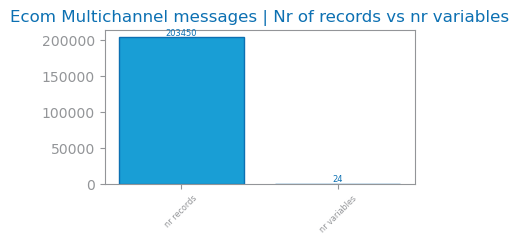

In [37]:
figure(figsize=(4, 2))
values: dict[str, int] = {"nr records": data.shape[0], "nr variables": data.shape[1]}
plot_bar_chart(
    list(values.keys()), list(values.values()), title=f"{file_tag} | Nr of records vs nr variables"
)
savefig(f"images/{file_tag}_records_variables.png") #save for later step
show()

## Missing values

Variables with their respective percentages of missing values:
platform: 52.27%
email_provider: 37.00%
total_count: 26.99%
subject_length: 19.46%
subject_with_personalization: 19.46%
subject_with_deadline: 19.46%
subject_with_emoji: 19.46%
subject_with_bonuses: 19.46%
subject_with_discount: 19.46%
subject_with_saleout: 19.46%
topic: 0.81%


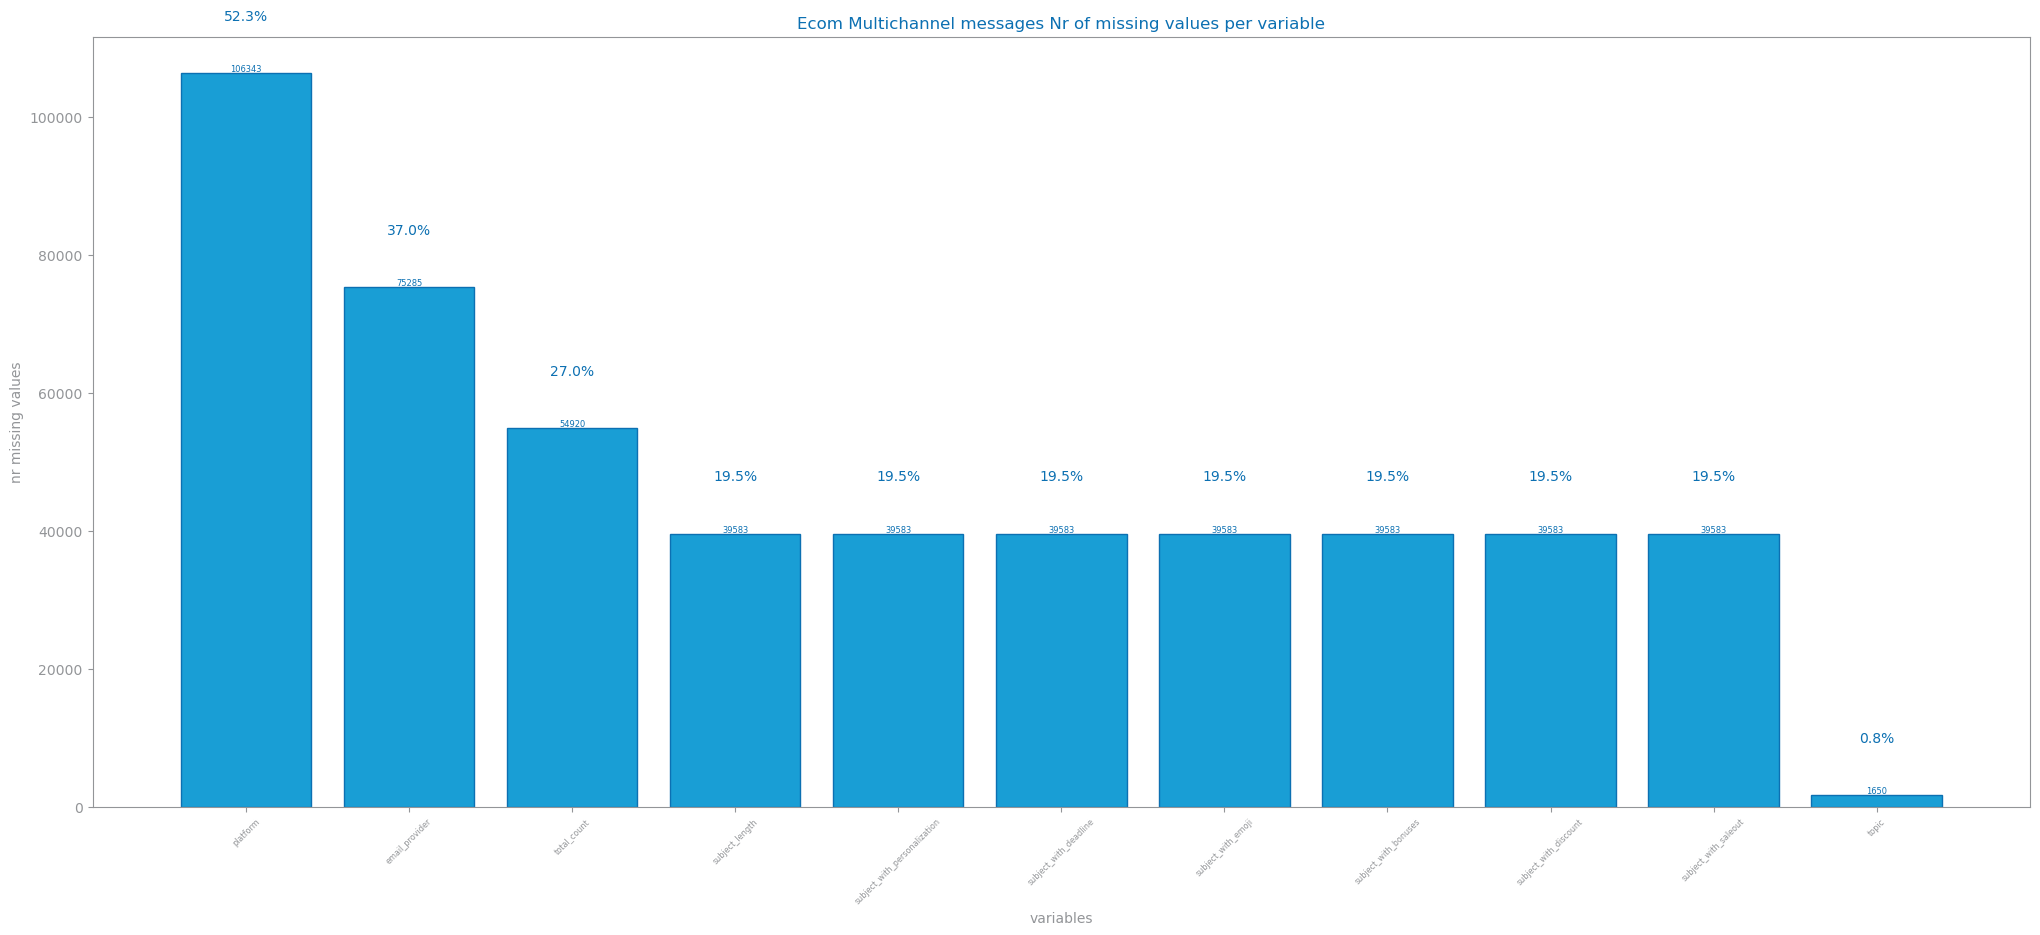

In [38]:
mv: dict[str, int] = {}
total_rows = len(data)

# Calculate the number of missing values and percentage for each variable
for var in data.columns:
    nr: int = data[var].isna().sum()
    if nr > 0:
        percentage = (nr / total_rows) * 100
        mv[var] = (nr, percentage)

# Sort the dictionary by the number of missing values in descending order
sorted_mv = dict(sorted(mv.items(), key=lambda item: item[1][0], reverse=True))

variables = list(sorted_mv.keys())
missing_values = [val[0] for val in sorted_mv.values()]
percentages = [val[1] for val in sorted_mv.values()]

# Print the list of variables with their respective percentages of missing values
print("Variables with their respective percentages of missing values:")
for var, perc in zip(variables, percentages):
    print(f"{var}: {perc:.2f}%")

# Plotting the bar chart
figure(figsize=(25, 10))  # (width, height)

plot_bar_chart(
    variables,
    missing_values,
    title=f"{file_tag} Nr of missing values per variable",
    xlabel="variables",
    ylabel="nr missing values",
)

# Annotate the bars with percentages
for i, (var, perc) in enumerate(zip(variables, percentages)):
    text(i, missing_values[i] + max(missing_values) * 0.08, f"{perc:.1f}%", ha="center", va="center_baseline")

# Display the chart
show()


## Variables types

In [39]:
data.dtypes

platform                                     object
email_provider                               object
sent_at                         datetime64[ns, UTC]
is_clicked                                   object
campaign_type                                object
channel_cmp                                  object
topic                                        object
total_count                                 float64
subject_length                              float64
subject_with_personalization                 object
subject_with_deadline                        object
subject_with_emoji                           object
subject_with_bonuses                         object
subject_with_discount                        object
subject_with_saleout                         object
day_of_year                                   int64
week_of_month                                 int64
is_weekend                                     bool
day_of_week_nr                                int64
day_of_month

In [40]:
from pandas import Series, to_numeric, to_datetime


def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    for c in df.columns:
        if 2 == nr_values[c]:
            variable_types["binary"].append(c)
            df[c].astype("bool")
        else:
        # Check if the column is already of datetime type
            if pd.api.types.is_datetime64_any_dtype(df[c]):
                variable_types["date"].append(c)
            else:
                try:
                    to_numeric(df[c], errors="raise")
                    variable_types["numeric"].append(c)
                except ValueError:
                    try:
                        df[c] = to_datetime(df[c], errors="raise")
                        variable_types["date"].append(c)
                    except ValueError:
                        variable_types["symbolic"].append(c)

    return variable_types

{'numeric': ['total_count', 'subject_length', 'day_of_year', 'week_of_month', 'day_of_week_nr', 'day_of_month', 'hour', 'min'], 'binary': ['is_clicked', 'subject_with_personalization', 'subject_with_deadline', 'subject_with_emoji', 'subject_with_bonuses', 'subject_with_discount', 'subject_with_saleout', 'is_weekend'], 'date': ['sent_at'], 'symbolic': ['platform', 'email_provider', 'campaign_type', 'channel_cmp', 'topic', 'month', 'time_of_day']}


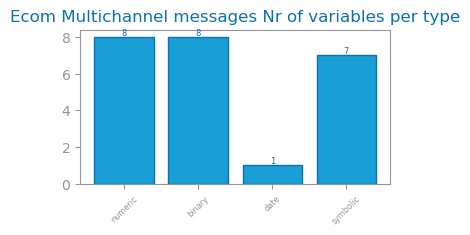

In [41]:
variable_types: dict[str, list] = get_variable_types(data)
print(variable_types)
counts: dict[str, int] = {}
for tp in variable_types.keys():
    counts[tp] = len(variable_types[tp])

figure(figsize=(4, 2))
plot_bar_chart(
    list(counts.keys()), list(counts.values()), title=f"{file_tag} Nr of variables per type"
)
savefig(f"./{file_tag}_variable_types.png") 
show()

In [42]:
# Calculate the number of distinct values for each column
distinct_counts = {var_type: {col: data[col].nunique() for col in cols} for var_type, cols in variable_types.items()}

# Print the results
for var_type, counts in distinct_counts.items():
    print(f"{var_type.capitalize()} Variables:")
    for col, count in counts.items():
        print(f"  {col}: {count} distinct values")
    print()

Numeric Variables:
  total_count: 36 distinct values
  subject_length: 29 distinct values
  day_of_year: 45 distinct values
  week_of_month: 5 distinct values
  day_of_week_nr: 7 distinct values
  day_of_month: 31 distinct values
  hour: 23 distinct values
  min: 60 distinct values

Binary Variables:
  is_clicked: 2 distinct values
  subject_with_personalization: 2 distinct values
  subject_with_deadline: 2 distinct values
  subject_with_emoji: 2 distinct values
  subject_with_bonuses: 2 distinct values
  subject_with_discount: 2 distinct values
  subject_with_saleout: 2 distinct values
  is_weekend: 2 distinct values

Date Variables:
  sent_at: 87146 distinct values

Symbolic Variables:
  platform: 4 distinct values
  email_provider: 88 distinct values
  campaign_type: 3 distinct values
  channel_cmp: 3 distinct values
  topic: 16 distinct values
  month: 3 distinct values
  time_of_day: 4 distinct values



# Distribution

In [43]:
summary5: DataFrame = data.describe(include="all")
summary5

platform email_provider                              sent_at  \
count     97107         128165                               203450   
unique        4             88                                  NaN   
top     desktop        mail.ru                                  NaN   
freq      73760          69480                                  NaN   
mean        NaN            NaN  2021-05-18 19:39:45.838382848+00:00   
min         NaN            NaN            2021-04-30 05:00:37+00:00   
25%         NaN            NaN            2021-05-06 09:35:24+00:00   
50%         NaN            NaN            2021-05-20 13:00:26+00:00   
75%         NaN            NaN  2021-05-26 15:00:21.750000128+00:00   
max         NaN            NaN            2021-06-14 19:38:49+00:00   
std         NaN            NaN                                  NaN   

       is_clicked campaign_type channel_cmp     topic   total_count  \
count      203450        203450      203450    201800  1.485300e+05   
unique          2             3           3        16           NaN   
top             f          bulk       email  sale out           NaN   
freq       176675        148530       88582    146238           NaN   
mean          NaN           NaN         NaN       NaN  6.166253e+05   
min           NaN           NaN         NaN       NaN  4.000000e+00   
25%           NaN           NaN         NaN       NaN  2.319720e+05   
50%           NaN           NaN         NaN       NaN  7.813540e+05   
75%           NaN           NaN         NaN       NaN  9.218380e+05   
max           NaN           NaN         NaN       NaN  1.045217e+06   
std           NaN           NaN         NaN       NaN  3.707504e+05   

        subject_length subject_with_personalization  ... subject_with_saleout  \
count    163867.000000                       163867  ...               163867   
unique             NaN                            2  ...                    2   
top                NaN                        False  ...                False   
freq               NaN                       163580  ...               158692   
mean        111.551478                          NaN  ...                  NaN   
min          32.000000                          NaN  ...                  NaN   
25%          97.000000                          NaN  ...                  NaN   
50%         109.000000                          NaN  ...                  NaN   
75%         133.000000                          NaN  ...                  NaN   
max         185.000000                          NaN  ...                  NaN   
std          20.403058                          NaN  ...                  NaN   

          day_of_year  week_of_month is_weekend day_of_week_nr   day_of_month  \
count   203450.000000  203450.000000     203450  203450.000000  203450.000000   
unique            NaN            NaN          2            NaN            NaN   
top               NaN            NaN      False            NaN            NaN   
freq              NaN            NaN     186467            NaN            NaN   
mean       138.428607       2.644502        NaN       3.045643      16.314490   
min        120.000000       1.000000        NaN       0.000000       1.000000   
25%        126.000000       1.000000        NaN       2.000000       7.000000   
50%        140.000000       3.000000        NaN       3.000000      19.000000   
75%        146.000000       4.000000        NaN       4.000000      22.000000   
max        165.000000       5.000000        NaN       6.000000      31.000000   
std         12.280734       1.356169        NaN       1.422064       8.987874   

         month           hour            min  time_of_day  
count   203450  203450.000000  203450.000000       203450  
unique       3            NaN            NaN            4  
top        May            NaN            NaN      Morning  
freq    146342            NaN            NaN       175552  
mean       NaN       8.906331      27.711251          N

Numerical variables indiv

In [44]:
#Use a variable from the dataset - Note: i dont have numeric variables in my dataset 
var: str = "subject_length"
print(f"Summary for {var} variable:")
print("\tCount: ", summary5[var]["count"])
print("\tMean: ", summary5[var]["mean"])
print("\tStDev: ", summary5[var]["std"])
print("\tMin: ", summary5[var]["min"])
print("\tQ1: ", summary5[var]["25%"])
print("\tMedian: ", summary5[var]["50%"])
print("\tQ3: ", summary5[var]["75%"])
print("\tMax: ", summary5[var]["max"])

Summary for subject_length variable:
	Count:  163867.0
	Mean:  111.55147772278738
	StDev:  20.4030576181083
	Min:  32.0
	Q1:  97.0
	Median:  109.0
	Q3:  133.0
	Max:  185.0


Non-numerical variables indiv

In [45]:
var = "email_provider"
print(f"Summary for {var} variable:")
print("\tCount: ", summary5[var]["count"])
print("\tUnique: ", summary5[var]["unique"])
print("\tTop: ", summary5[var]["top"])
print("\tFreq: ", summary5[var]["freq"])

Summary for email_provider variable:
	Count:  128165
	Unique:  88
	Top:  mail.ru
	Freq:  69480


## Numeric variables

In [46]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
#from dslabs_functions import define_grid, HEIGHT


Fixing date type as numeric

In [47]:
#date_columns = ['date', 'sent_at', "opened_first_time_at", "opened_last_time_at", "clicked_first_time_at", "clicked_last_time_at",
#                "unsubscribed_at", "hard_bounced_at", "soft_bounced_at", "complained_at", "blocked_at", "purchased_at", "created_at",
#                  "updated_at", "first_purchase_date", "started_at", "finished_at"]
#
## Convert all listed columns to datetime
#for col in date_columns:
#    data[col] = pd.to_datetime(data[col], errors='coerce')


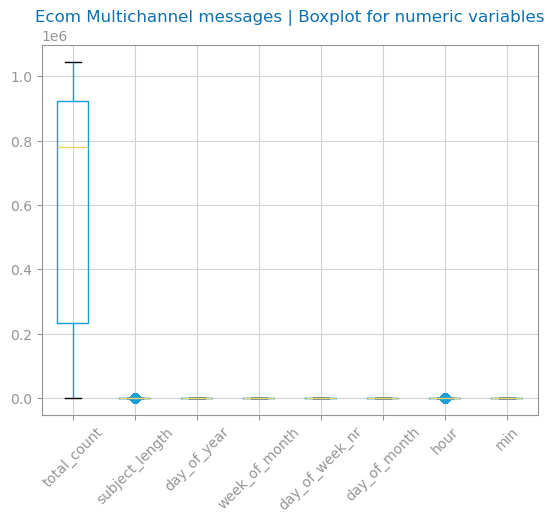

In [48]:
from matplotlib.pyplot import savefig, show, title
#from dslabs_functions import get_variable_types

variables_types: dict[str, list] = get_variable_types(data)
numeric: list[str] = variables_types["numeric"]
if [] != numeric:
    data[numeric].boxplot(rot=45)
    title(f'{file_tag} | Boxplot for numeric variables')  # Correct way to set title
    savefig(f"./{file_tag}_global_boxplot.png")
    show()
else:
    print("There are no numeric variables.")

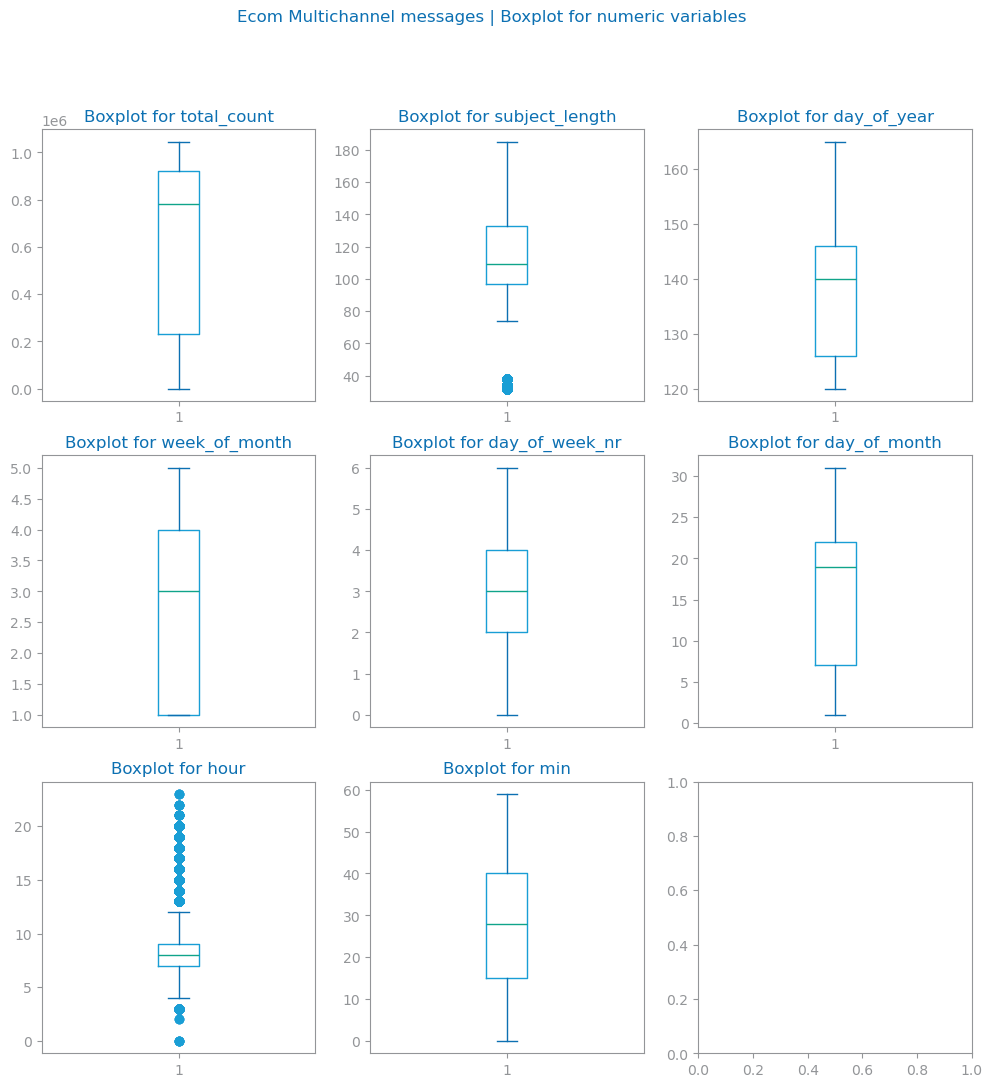

In [62]:

numeric: list[str] = variable_types["numeric"]

if [] != numeric:
    rows: int
    cols: int
    rows, cols = define_grid(len(numeric))
    fig: Figure
    axs: ndarray
    title: f'{file_tag} Boxplot for numeric variables'
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    fig.suptitle(f'{file_tag} | Boxplot for numeric variables')

    i, j = 0, 0
    for n in range(len(numeric)):
        axs[i, j].set_title("Boxplot for %s" % numeric[n])
        axs[i, j].boxplot(data[numeric[n]].dropna().values)
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"./{file_tag}_single_boxplots.png")
    show()
else:
    print("There are no numeric variables.")

## Outliers
Standard Deviation Method (stdev):
- A higher number of outliers detected by this method might suggest that the data points are far from the mean, indicating possible anomalies or extreme values
- works well on normally distrib data

IQR:
- less sensitive to skewed data and works well with data that is not normally distributed because it relies on the spread of the middle 50% of the data
- A higher number of outliers detected by this method indicates that there are extreme values relative to the majority of data points. The IQR method is robust and less influenced by extreme values in the dataset

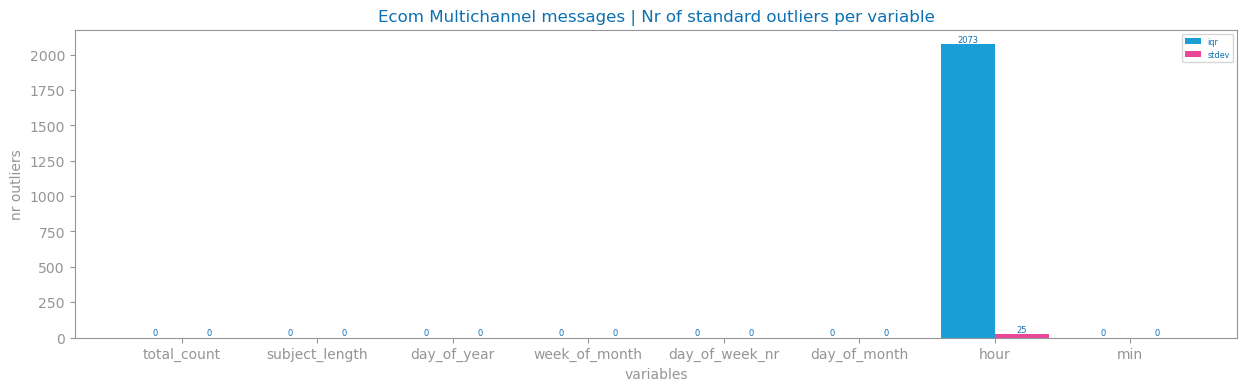

In [65]:
import numpy as np
from pandas import Series, DataFrame
from matplotlib.pyplot import figure, savefig, show
#from dslabs_functions import plot_multibar_chart

NR_STDEV: int = 2
IQR_FACTOR: float = 1.5


def determine_outlier_thresholds_for_var(
    summary5: Series, std_based: bool = True, threshold: float = NR_STDEV
) -> tuple[float, float]:
    top: float = 0
    bottom: float = 0
    
    if std_based:
        # Check for NaN or NaT before doing the calculation
        if pd.isna(summary5["mean"]) or pd.isna(summary5["std"]):
            return np.nan, np.nan
        std: float = threshold * summary5["std"]
        top = summary5["mean"] + std
        bottom = summary5["mean"] - std
    else:
        if pd.isna(summary5["75%"]) or pd.isna(summary5["25%"]):
            return np.nan, np.nan
        iqr: float = threshold * (summary5["75%"] - summary5["25%"])
        top = summary5["75%"] + iqr
        bottom = summary5["25%"] - iqr

    return top, bottom


def count_outliers(
    data: DataFrame,
    numeric: list[str],
    nrstdev: int = NR_STDEV,
    iqrfactor: float = IQR_FACTOR,
) -> dict:
    outliers_iqr: list = []
    outliers_stdev: list = []
    valid_numeric: list = []  # This will store only the variables with valid outlier counts
    summary5: DataFrame = data[numeric].describe()

    for var in numeric:
        top: float
        bottom: float
        
        # Check if we can compute std-based outliers
        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=True, threshold=nrstdev
        )
        if not pd.isna(top) and not pd.isna(bottom):
            outliers_stdev_count = (
                data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]
            )
            outliers_stdev.append(outliers_stdev_count)

            # Check if we can compute IQR-based outliers
            top, bottom = determine_outlier_thresholds_for_var(
                summary5[var], std_based=False, threshold=iqrfactor
            )
            if not pd.isna(top) and not pd.isna(bottom):
                outliers_iqr_count = (
                    data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]
                )
                outliers_iqr.append(outliers_iqr_count)
                valid_numeric.append(var)  # Add to valid list if both checks pass

    return {"iqr": outliers_iqr, "stdev": outliers_stdev, "valid_numeric": valid_numeric}


if numeric:
    outliers: dict[str, int] = count_outliers(data, numeric, nrstdev=4, iqrfactor=4.5)
    
    # Use only the valid variables for which we have calculated outliers
    valid_numeric = outliers["valid_numeric"]
    
    figure(figsize=(15, HEIGHT))
    plot_multibar_chart(
        valid_numeric,  # Use only valid numeric columns
        {"iqr": outliers["iqr"], "stdev": outliers["stdev"]},  # Use valid outliers
        title=f"{file_tag} | Nr of standard outliers per variable",
        xlabel="variables",
        ylabel="nr outliers",
        percentage=False,
    )
    savefig(f"./{file_tag}_outliers.png")
    show()
else:
    print("There are no numeric variables.")


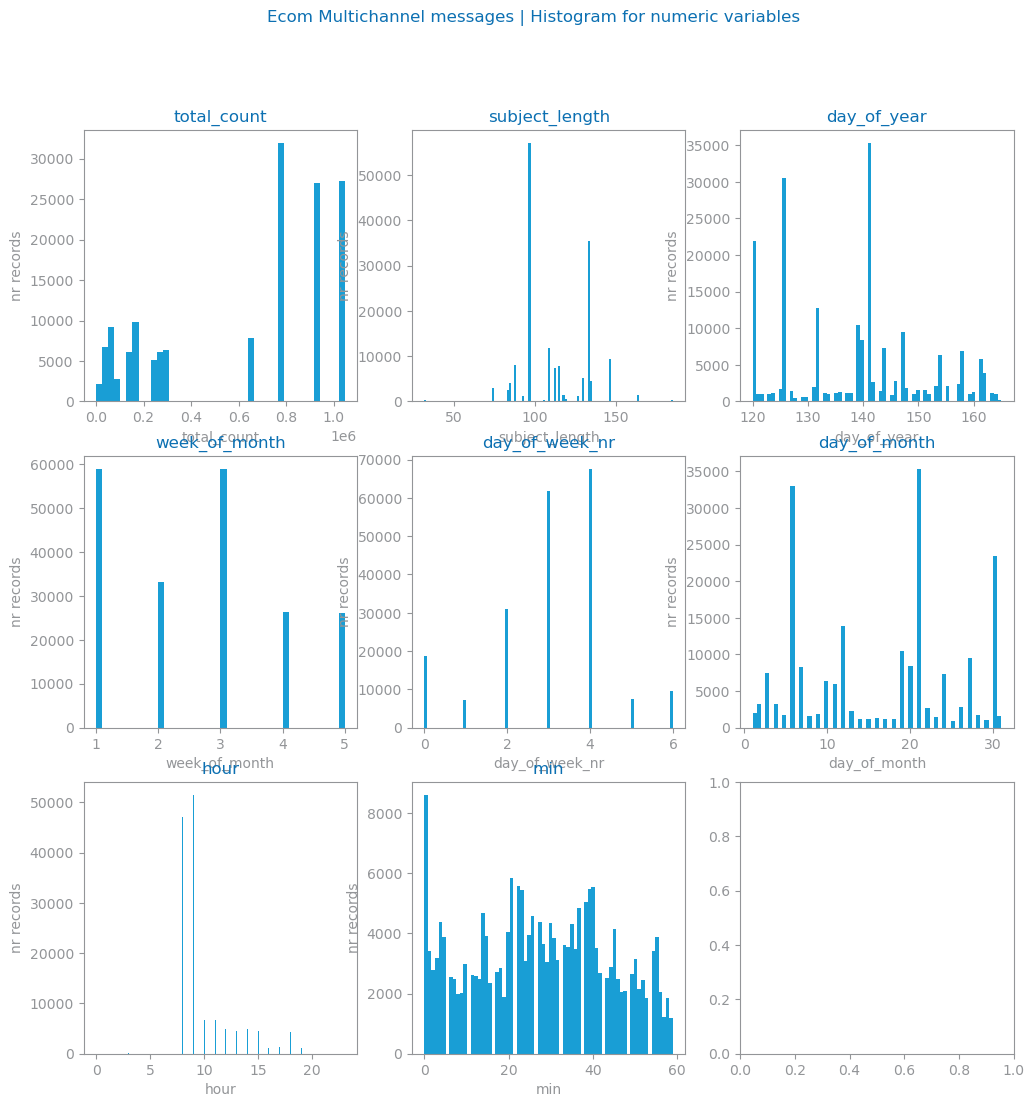

In [51]:
#from dslabs_functions import set_chart_labels


if [] != numeric:
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i: int
    j: int
    i, j = 0, 0
    fig.suptitle(f'{file_tag} | Histogram for numeric variables')
    for n in range(len(numeric)):
        set_chart_labels(
            axs[i, j],
            title=f"{numeric[n]}",
            xlabel=numeric[n],
            ylabel="nr records",
        )
        axs[i, j].hist(data[numeric[n]].dropna().values, "auto")
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    #savefig(f"./{file_tag}_single_histograms_numeric.png")
    show()
else:
    print("There are no numeric variables.")

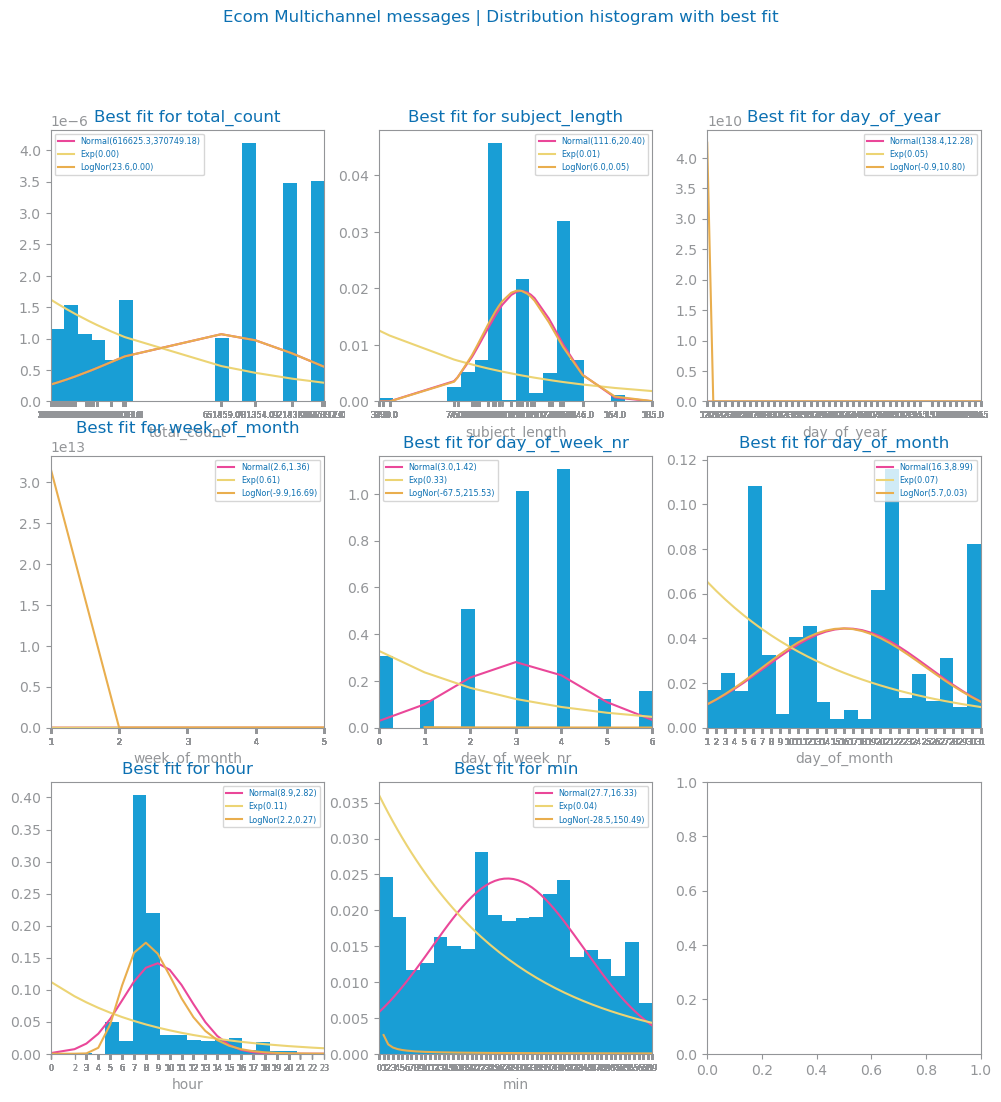

In [52]:
from numpy import log
from pandas import Series
from scipy.stats import norm, expon, lognorm
from matplotlib.axes import Axes
#from dslabs_functions import plot_multiline_chart


def compute_known_distributions(x_values: list) -> dict:
    distributions = dict()
    if len(x_values) > 0:  # Check for empty list
        # Gaussian
        mean, sigma = norm.fit(x_values)
        distributions["Normal(%.1f,%.2f)" % (mean, sigma)] = norm.pdf(x_values, mean, sigma)
        # Exponential
        loc, scale = expon.fit(x_values)
        distributions["Exp(%.2f)" % (1 / scale)] = expon.pdf(x_values, loc, scale)
        # LogNorm
        sigma, loc, scale = lognorm.fit(x_values)
        distributions["LogNor(%.1f,%.2f)" % (log(scale), sigma)] = lognorm.pdf(
            x_values, sigma, loc, scale
        )
    return distributions


def histogram_with_distributions(ax: Axes, series: Series, var: str):
    values: list = series.sort_values().to_list()
    if len(values) > 0:  # Check for empty values list
        ax.hist(values, 20, density=True)
        distributions: dict = compute_known_distributions(values)
        plot_multiline_chart(
            values,
            distributions,
            ax=ax,
            title="Best fit for %s" % var,
            xlabel=var,
            ylabel="",
        )
    else:
        print(f"No data available for {var}")


if [] != numeric:
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i, j = 0, 0
    fig.suptitle(f'{file_tag} | Distribution histogram with best fit')
    for n in range(len(numeric)):
        histogram_with_distributions(axs[i, j], data[numeric[n]].dropna(), numeric[n])
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"./{file_tag}_histogram_numeric_distribution.png")
    show()
else:
    print("There are no numeric variables.")


## Symbolic Variables

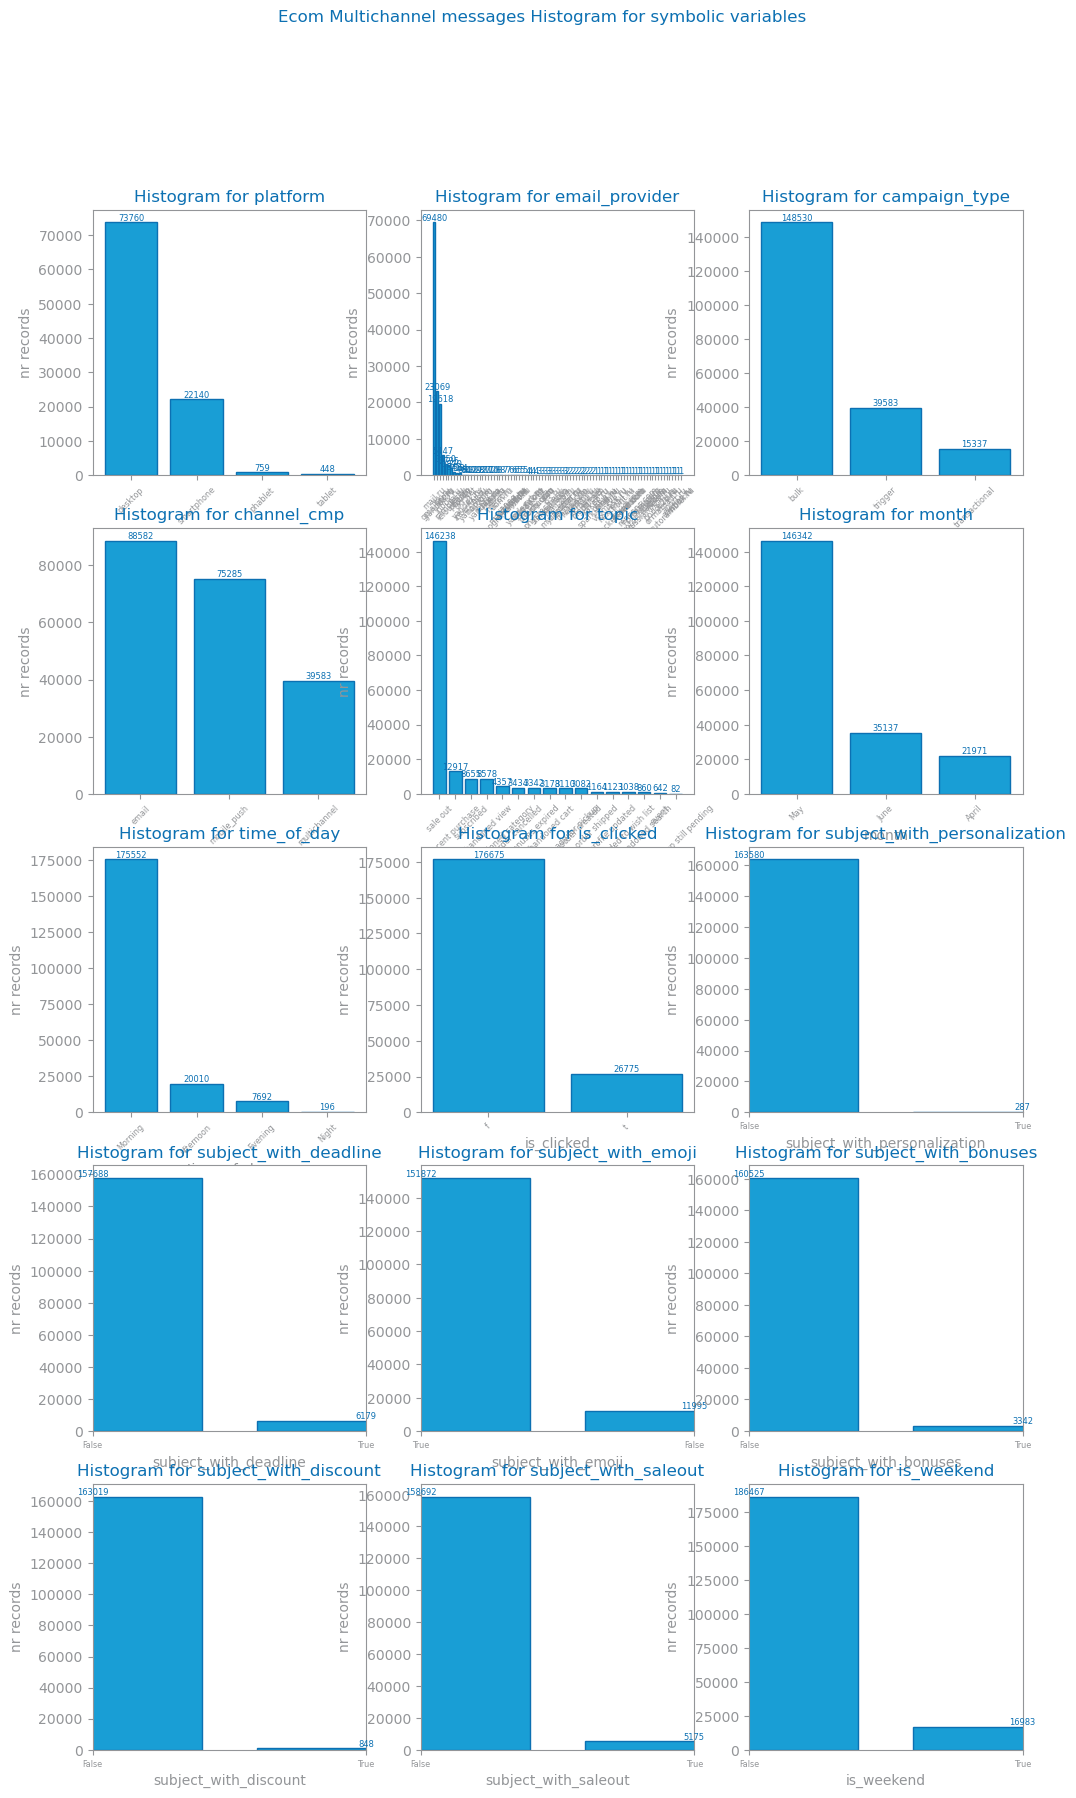

In [53]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
#from dslabs_functions import define_grid, HEIGHT



symbolic: list[str] = variable_types["symbolic"] + variable_types["binary"]
if [] != symbolic:
    rows, cols = define_grid(len(symbolic))
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i, j = 0, 0
    fig.suptitle(f'{file_tag} Histogram for symbolic variables')
    for n in range(len(symbolic)):
        counts: Series = data[symbolic[n]].value_counts()
        plot_bar_chart(
            counts.index.to_list(),
            counts.to_list(),
            ax=axs[i, j],
            title=f"Histogram for %s" % symbolic[n],
            xlabel=symbolic[n],
            ylabel="nr records",
            percentage=False,
        )
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"./{file_tag}_histograms_symbolic.png")
    show()
else:
    print("There are no symbolic variables.")

## Balancing and Class distribution


Counts:
is_clicked
f    176675
t     26775
Name: count, dtype: int64

Percentages:
is_clicked
f    86.839518
t    13.160482
Name: count, dtype: float64


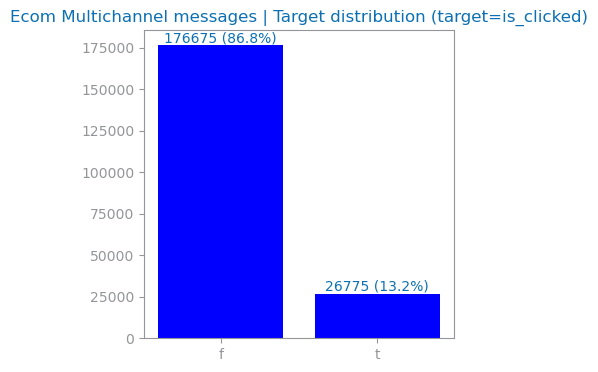

In [67]:
import matplotlib.pyplot as plt
import numpy as np

target = "is_clicked"

values: Series = data[target].value_counts()
percentages: Series = (values / values.sum()) * 100  # Calculate the percentage for each category

print("Counts:")
print(values)
print("\nPercentages:")
print(percentages)

plt.figure(figsize=(4, 4))

bars = plt.bar(values.index.to_list(), values.to_list(), color='blue')

plt.title(f"{file_tag} | Target distribution (target={target})")

for bar, p in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval} ({p:.1f}%)', ha='center', va='bottom')
plt.savefig(f"./{file_tag}_class_distribution.png")

plt.show()


# Granularity

## Dates

In [55]:
from pandas import DataFrame
#ver para weekend, dia da semana (mon, tue, thu), hora, minuto. estudar a granularidade destas variaveis.
#variáveis ciclicas.

def derive_date_variables(data: DataFrame, date_vars: list[str]) -> DataFrame:
    for date in date_vars:
        data[date + "_year"] = data[date].dt.year
        data[date + "_quarter"] = data[date].dt.quarter
        data[date + "_month"] = data[date].dt.month
        data[date + "_day"] = data[date].dt.day
    return data

In [56]:
from pandas import Series, to_numeric, to_datetime


def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    for c in df.columns:
        if 2 == nr_values[c]:
            variable_types["binary"].append(c)
            df[c].astype("bool")
        else:
        # Check if the column is already of datetime type
            if pd.api.types.is_datetime64_any_dtype(df[c]):
                variable_types["date"].append(c)
            else:
                try:
                    to_numeric(df[c], errors="raise")
                    variable_types["numeric"].append(c)
                except ValueError:
                    try:
                        df[c] = to_datetime(df[c], errors="raise")
                        variable_types["date"].append(c)
                    except ValueError:
                        variable_types["symbolic"].append(c)

    return variable_types

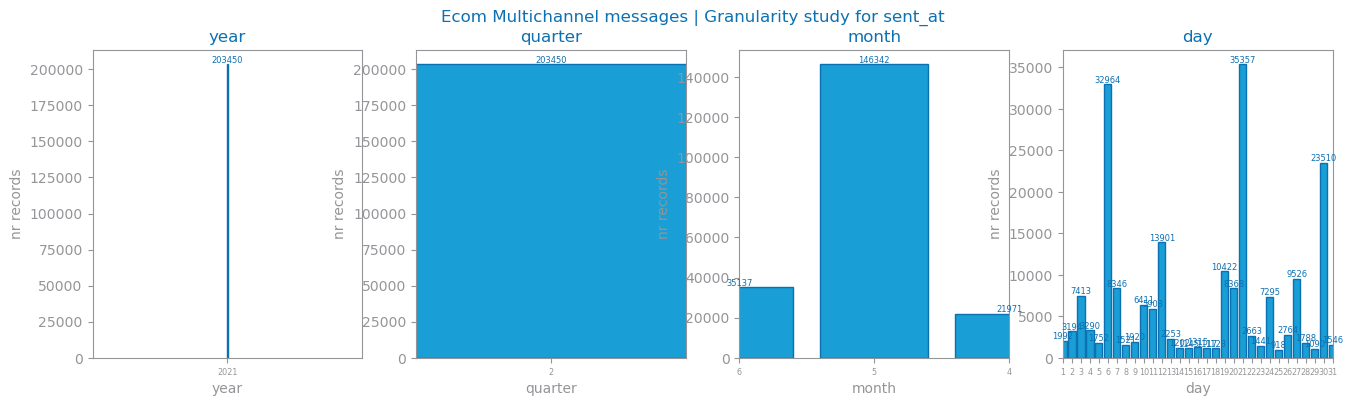

In [57]:
from numpy import ndarray
from pandas import Series, read_csv
from matplotlib.figure import Figure
from matplotlib.pyplot import subplots, savefig, show
#from dslabs_functions import plot_bar_chart, HEIGHT
#get_variable_types

def analyse_date_granularity(data: DataFrame, var: str, levels: list[str]) -> ndarray:
    cols: int = len(levels)
    fig: Figure
    axs: ndarray
    fig, axs = subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)
    fig.suptitle(f"{file_tag} | Granularity study for {var}")

    for i in range(cols):
        counts: Series[int] = data[var + "_" + levels[i]].value_counts()
        plot_bar_chart(
            counts.index.to_list(),
            counts.to_list(),
            ax=axs[0, i],
            title=levels[i],
            xlabel=levels[i],
            ylabel="nr records",
            percentage=False,
        )
    return axs


data: DataFrame = read_csv(
    filepath, index_col=None, parse_dates=True, dayfirst=True
)
variables_types: dict[str, list] = get_variable_types(data)
data_ext: DataFrame = derive_date_variables(data, variables_types["date"])

for v_date in variables_types["date"]:
    analyse_date_granularity(data, v_date, ["year", "quarter", "month", "day"])
    savefig(f"./{file_tag}_granularity_{v_date}.png")
    show()

# Sparsity
Note: scatter function is not able to deal with MV in non-numeric variables, and so we need to drop any of records having them (using the dropna method) heavy processing, use sampled data. -- use joao's sample_data in data_profiling


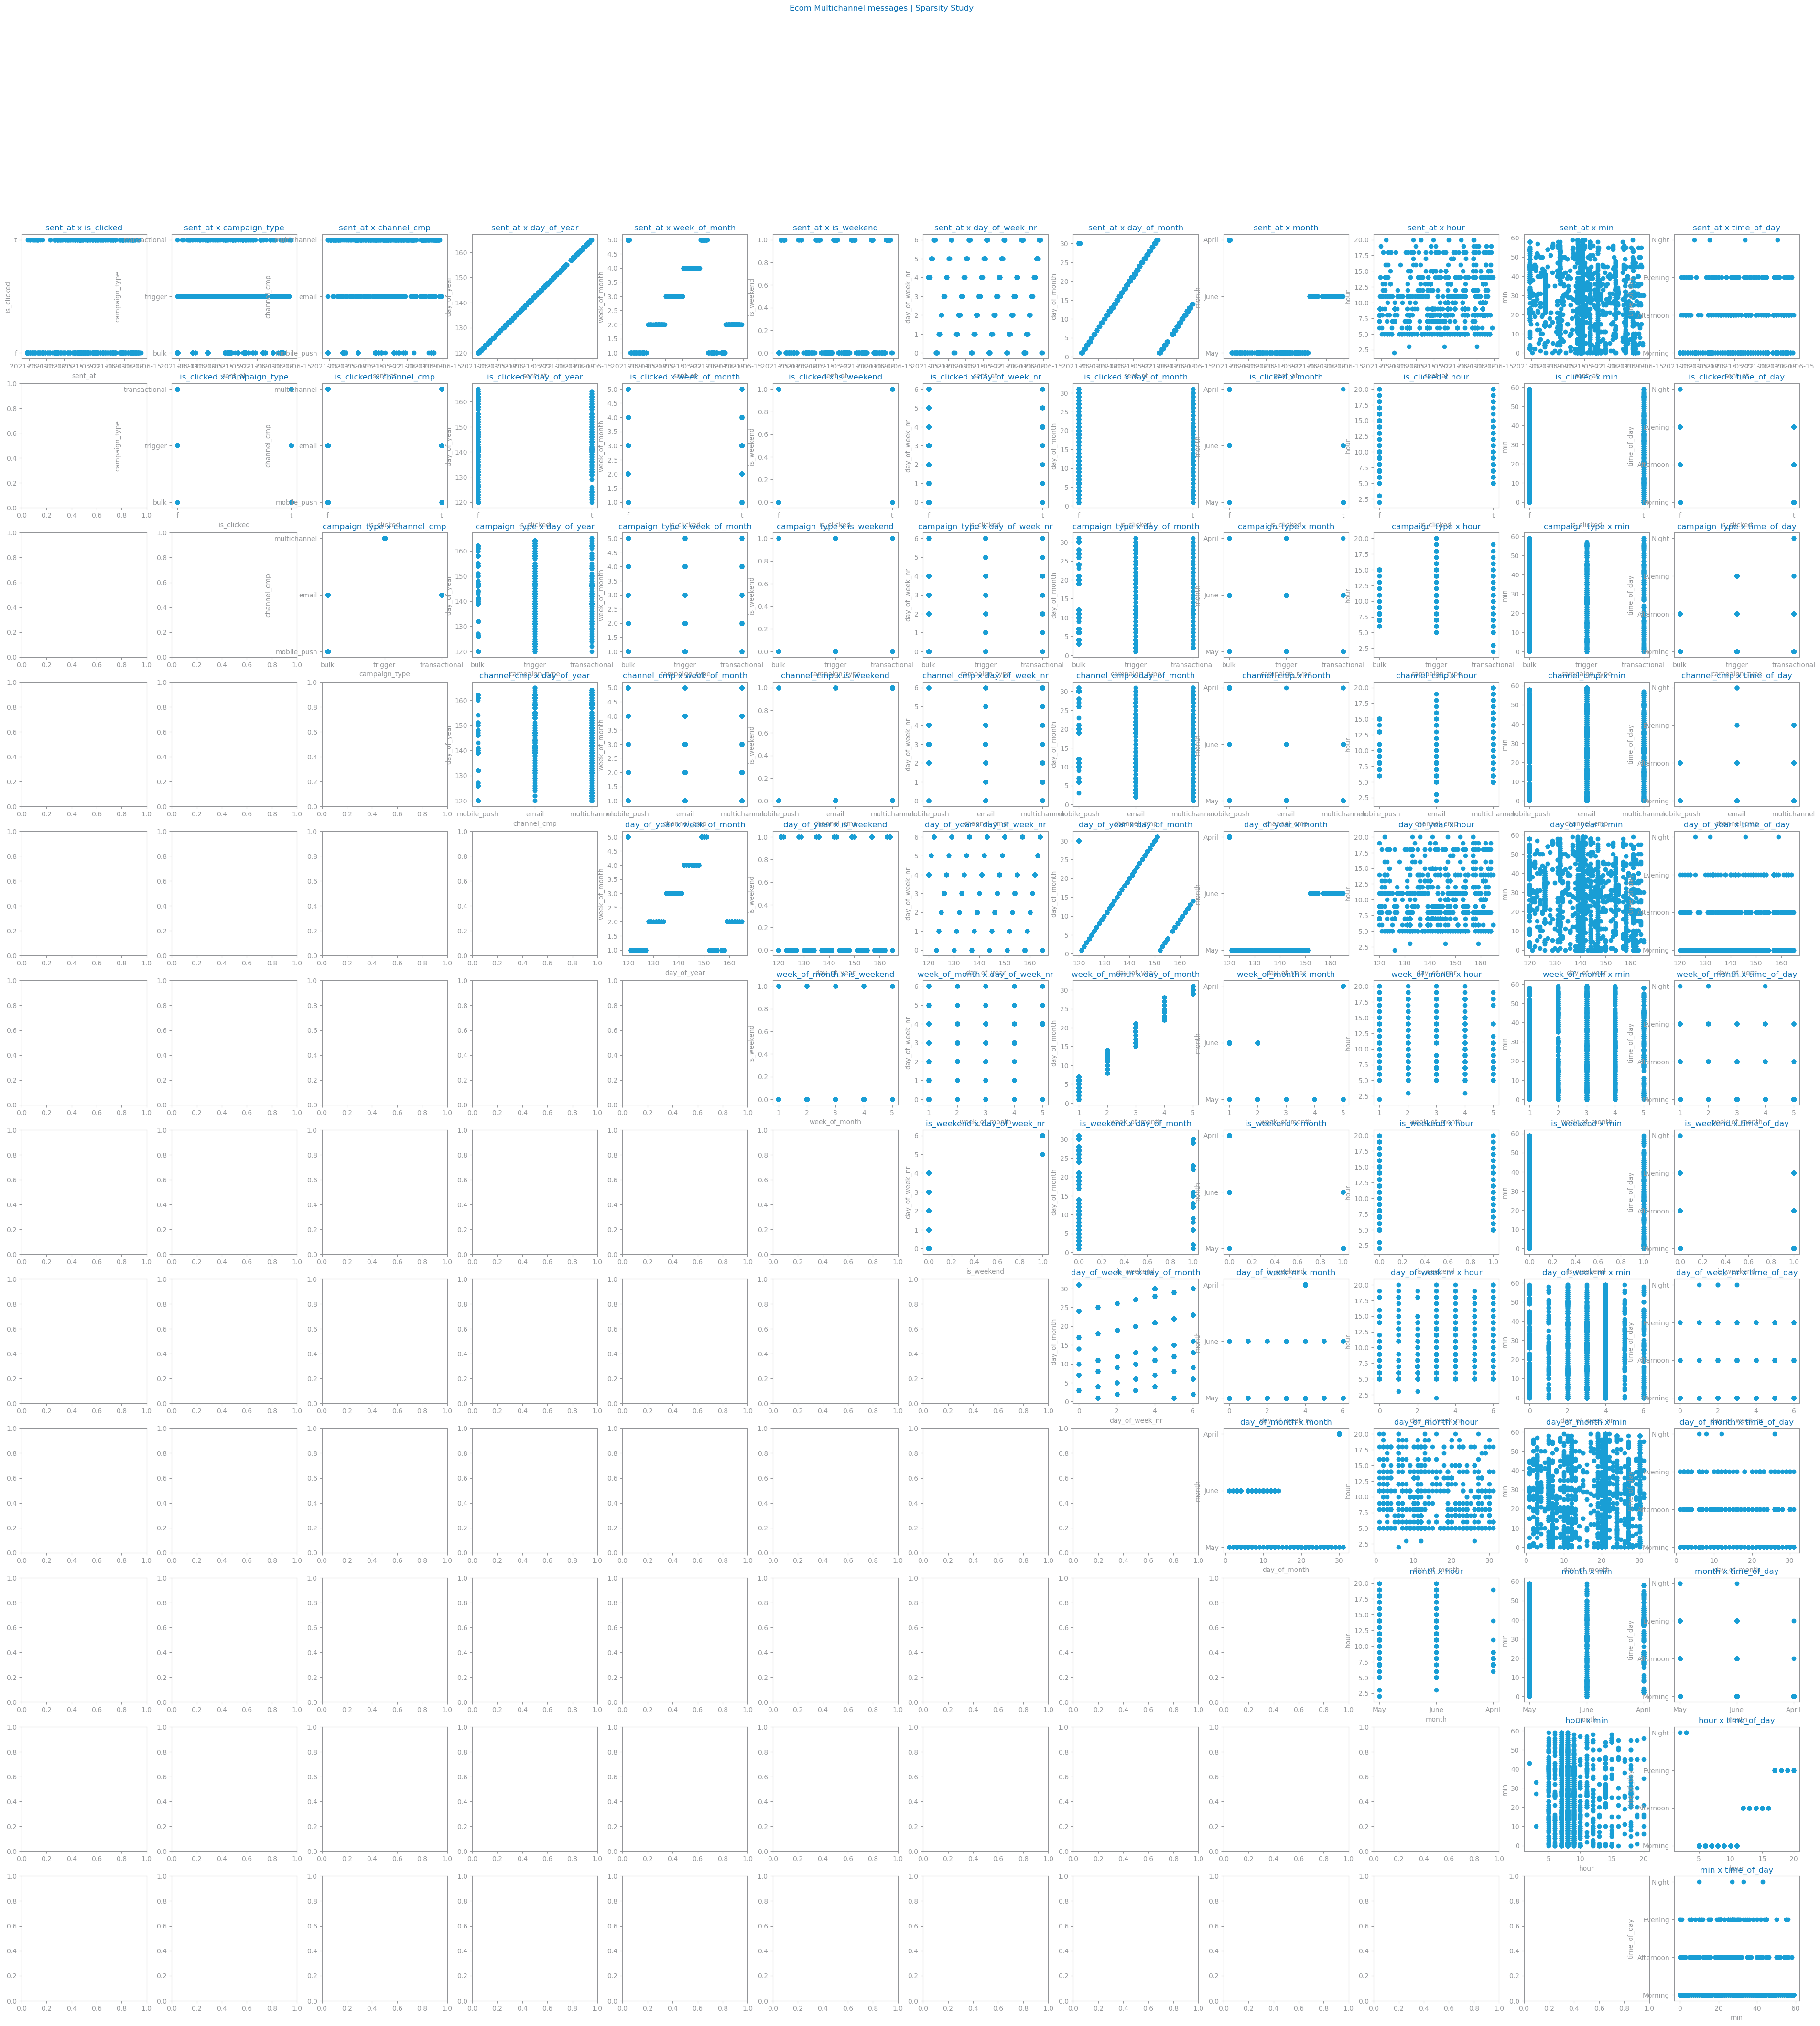

In [58]:
# Drop rows with NaN values
sampled_data = sampled_data.dropna(axis=1) #correr com axis=0 p retirar os records e nao as variaveis

# Check if data is empty after dropping NaNs
if sampled_data.empty:
    print("No data available after dropping NaN values.")
else:
    vars: list = sampled_data.columns.to_list()  # Ensure you're using data's columns

    if vars:  # Check if vars is not empty
        target = "is_clicked"
        n: int = len(vars) - 1
        fig: Figure
        axs: ndarray
        fig, axs = subplots(n, n, figsize=(n * HEIGHT, n * HEIGHT), squeeze=False)

        fig.suptitle(f'{file_tag} | Sparsity Study')


        for i in range(len(vars)):
            var1: str = vars[i]
            for j in range(i + 1, len(vars)):
                var2: str = vars[j]
                plot_multi_scatters_chart(sampled_data, var1, var2, ax=axs[i, j - 1])
        
        # Save the figure if needed
        savefig(f"./{file_tag}_sparsity_study.png")
        show()
    else:
        print("Sparsity class: there are no variables.")


Discriminate the records per class (target variable), in order to identify ranges of values specific for each class

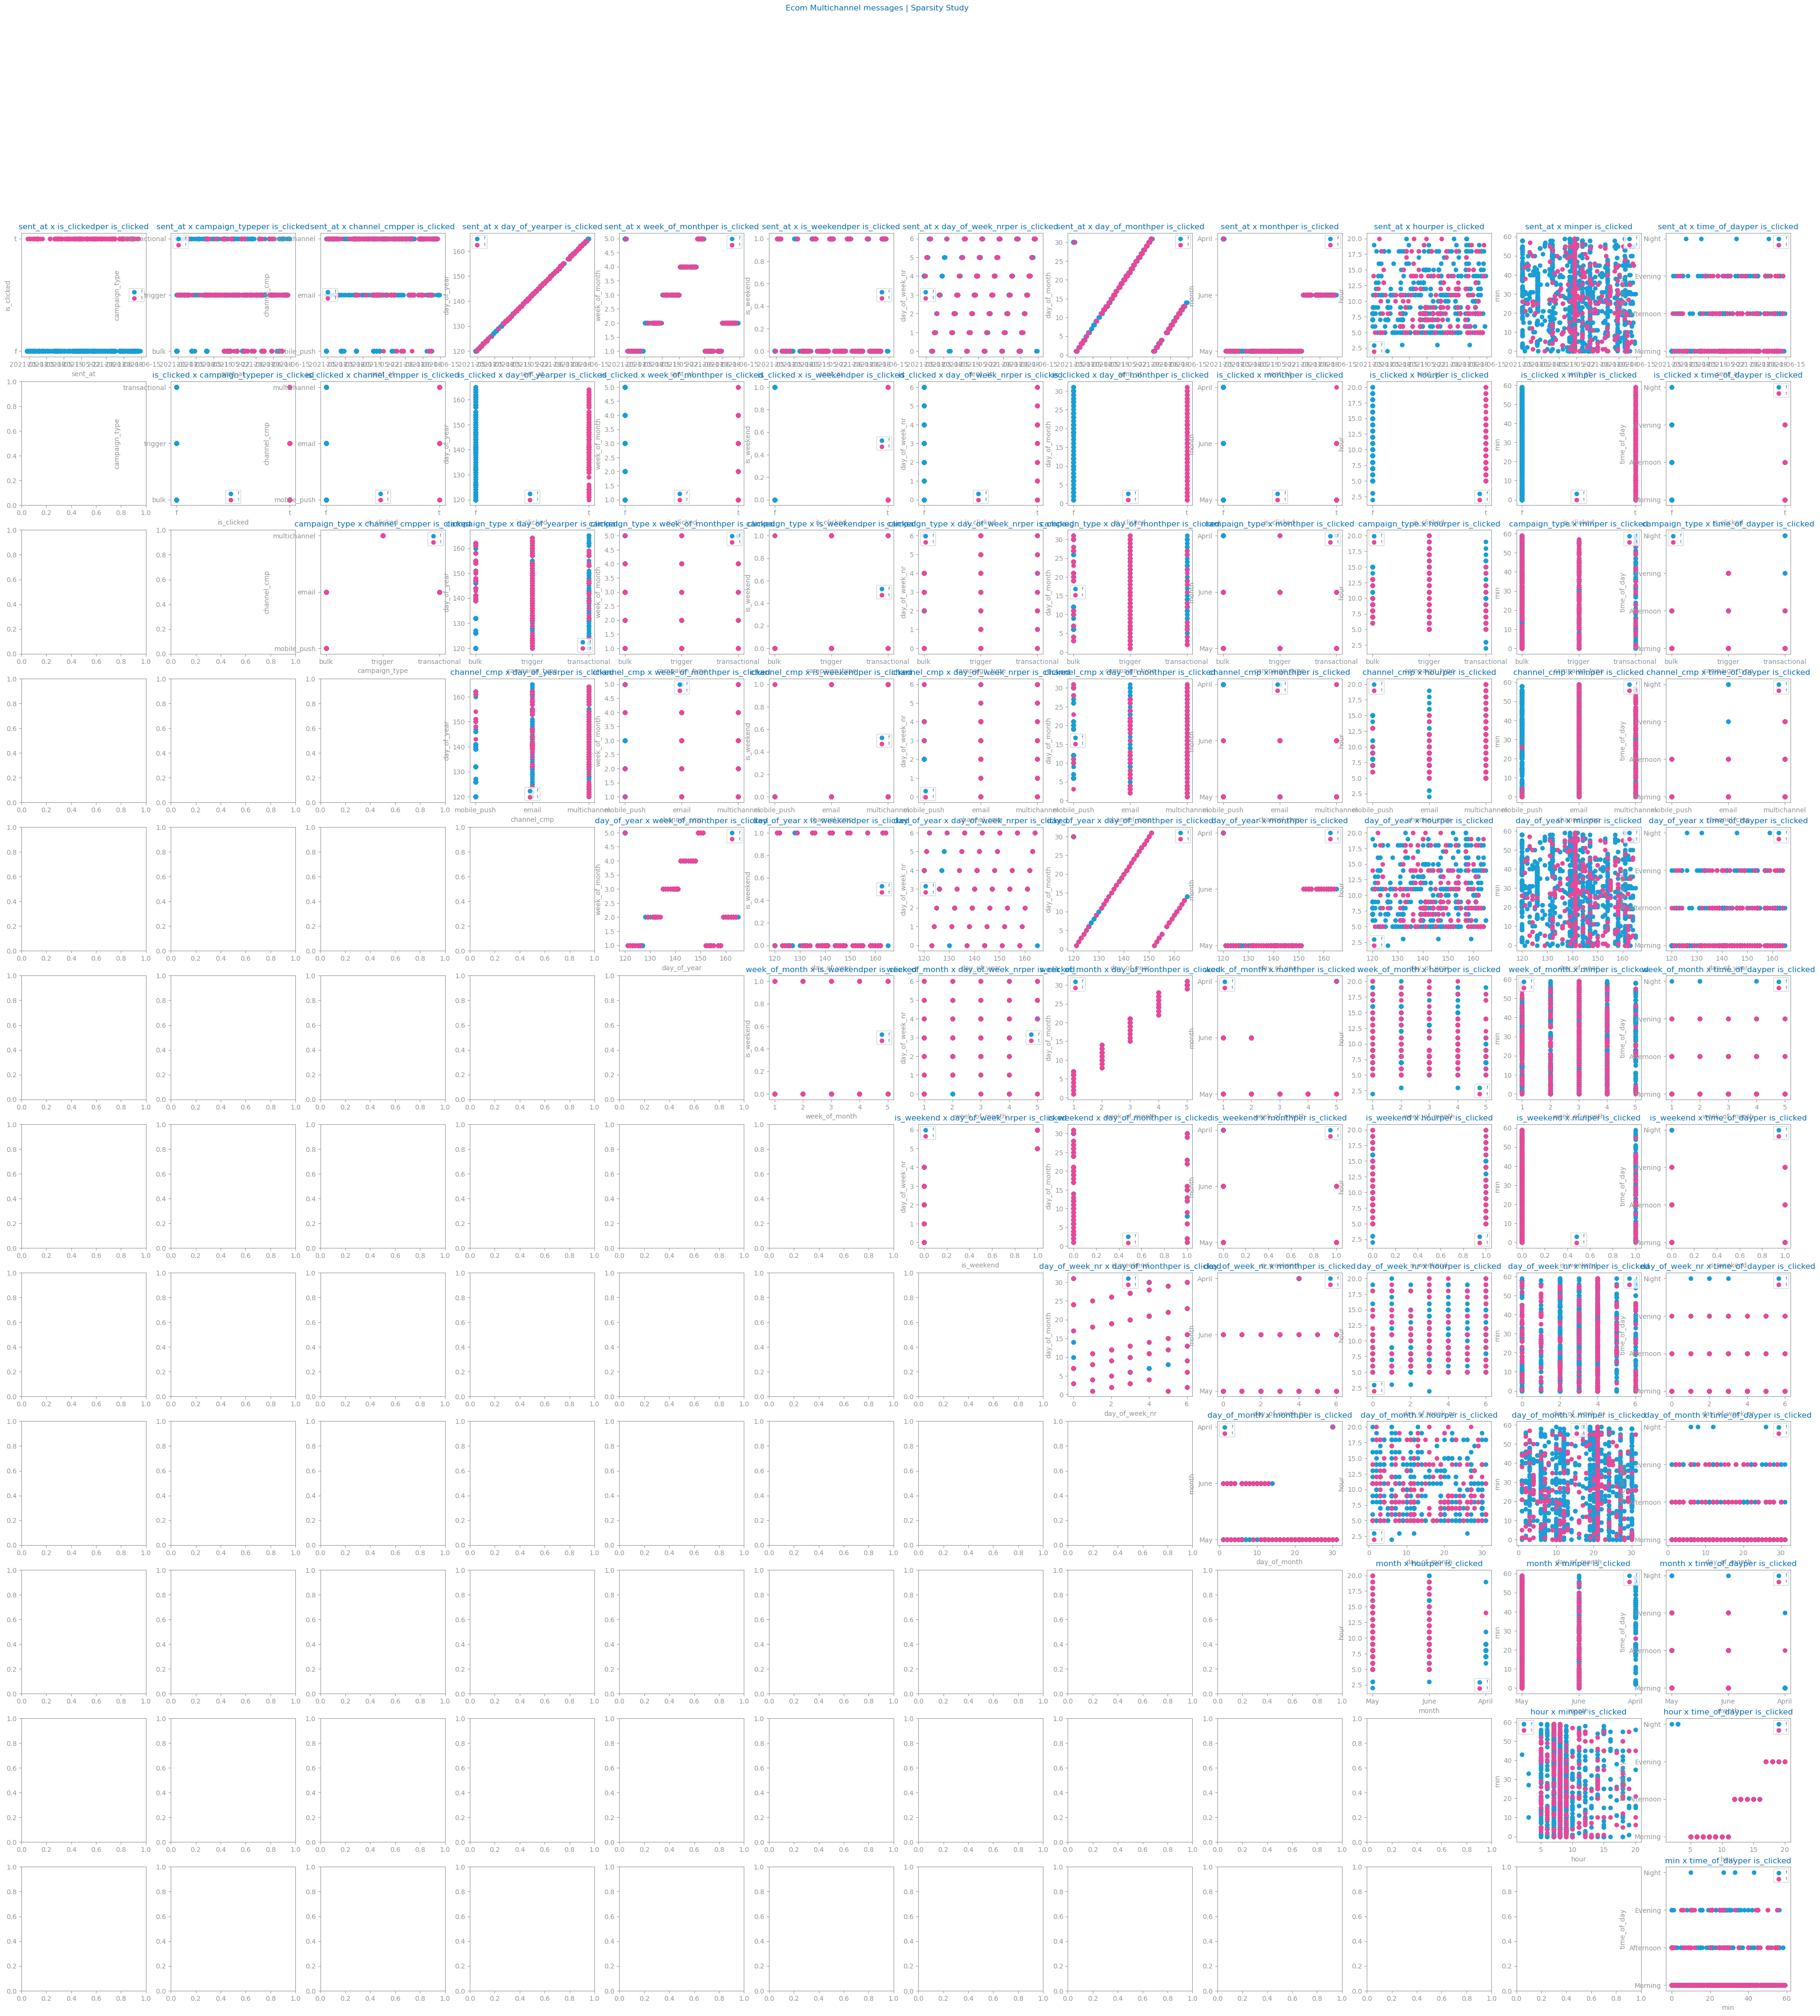

In [59]:
if [] != vars:
    target = "is_clicked"

    n: int = len(vars) - 1
    fig, axs = subplots(n, n, figsize=(n * HEIGHT, n * HEIGHT), squeeze=False)
    fig.suptitle(f'{file_tag} | Sparsity Study')

    for i in range(len(vars)):
        var1: str = vars[i]
        for j in range(i + 1, len(vars)):
            var2: str = vars[j]
            plot_multi_scatters_chart(sampled_data, var1, var2, target, ax=axs[i, j - 1])
    savefig(f"./{file_tag}_sparsity_per_class_study.png")
    show()
else:
    print("Sparsity per class: there are no variables.")

# Save df from preprocessing into a csv file

In [60]:
## Definir o caminho para salvar o arquivo CSV
#filepath = r'dataset/df_msg_data_prof.csv'
#
## Salvar o DataFrame em CSV
#data.to_csv(filepath, index=False)
#
#data.head()